# **Working with ICA, predicting online sales.**

First we load and preprocess the data  
Using our preprocessed picklefile, we load what dates and columns we want to use.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import time

start = time.perf_counter()

In [2]:
def read_data(start=None, stop=None, columns=None):
    df = pd.read_pickle('data/ica_summary.pkl')
    df = df.loc[start:stop, columns]
    return pd.DataFrame(df)

In [3]:
df = read_data(stop='2021-02-28', columns=['artiklar'])

In [4]:
df.tail()

,artiklar
2021-02-24,2049.0
2021-02-25,4205.0
2021-02-26,4716.0
2021-02-27,1282.0
2021-02-28,0.0


## **We continue to create and combine diffrent Features.**
(In this instance we are only using the one we found to give the most impact)

In [5]:
def icas_egna_features(df):
    features = {}
    
    # Adding what day of the week (mon, tue, wedn... ), represented with a number from 0-6
    def add_weekday(features):
        features['weekday'] = pd.Series(df.index.weekday, index=df.index)
    
    # Adding day of month, pretty straightforward 0-31
    def add_day_of_month(features):
        features['day_of_month'] = pd.Series(df.index.day, index=df.index)
    
    # Checking if it's a day before holiday. (If it is = 1, if not = 0)
    def add_before_mini_holiday(features):
        holidays = ['2020-12-31', '2021-01-05', '2021-04-01', '2021-04-03', '2021-04-04', '2020-05-20', '2020-05-30', '2020-06-05', '2020-06-19', '2020-10-30', '2020-12-24', '2020-12-25']
        features['holiday'] = pd.Series(np.where(df.index.isin(holidays), 1, 0), index=df.index)
    
    # Giving days before "big holidays", a value of 1, 2, 3 corresponding to the weight of their significance
    def add_before_holiday(features):
        features['before_holiday'] = pd.Series(0, index=df.index)
        before_holidays = ['2020-12-30', '2021-04-01', '2020-06-18', '2020-12-23']
        for holiday in before_holidays:
            for j, i in enumerate([3, 2, 1], 1):
                features['before_holiday'][pd.to_datetime(holiday) - pd.DateOffset(j)] = i
    
    # Adding value for Swedens normal payday, with the option to add pension pays aswell.
    def add_payday(features, payday, pension=False):
        if pension:
            if 'pension' not in features:
                features['pension'] = pd.Series(0, index=df.index) 
                series = features['pension']
            else:
                series = features['pension']
                
        if not pension:
            features['payday'] = pd.Series(0, index=df.index)
            series = features['payday']
        
        for i, day in enumerate(features['day_of_month']):
            if day == payday:
                if features['weekday'].iloc[i] in [5, 6] or features['holiday'].iloc[i]:
                    paydays = i - 1 if features['weekday'].iloc[i-1] not in [5, 6] or features['holiday'].iloc[i -1] else i - 2
                    series.iloc[paydays] = 1 
                else:
                    series.iloc[i] = 1
    
    add_weekday(features)
    add_day_of_month(features)
    add_before_mini_holiday(features)
    add_before_holiday(features)
    add_payday(features, 25)

    return features

In [6]:
features = icas_egna_features(df)

In [7]:
# This shows how many diffrent features we got
for key, value in features.items():
    print(type(value))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


## **Now to make them in to features combinations**
As said before, we will only be using one but this shows the the diffrent combinations types

In [8]:
# With the help from the lib, itertools we can send in the feature dict, and it creates all the diffrent combinations possible for us.
# Making the test even more thorough.
from itertools import combinations, chain

def feature_combinations(df, features):
    feature_combinations = list(chain.from_iterable([combinations(features, i) for i in range(1, len(features)+1)]))
    
    df_list = [df]
    for f_comb in feature_combinations:
        ts = df.copy()
        for feat in f_comb:
            ts[feat] = features[feat]
        df_list.append(ts)

    return df_list

In [9]:
df_list = feature_combinations(df, features)

#With this we are now at 32 diffrent feature combinations
print(len(df_list))

32


## **We are now ready to scale the data**
as you might have noticed we like to be thorough, so we hit it of with 3 diffrent scalers

In [10]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

def scale_data(df_list, unscaled=None):
    scaled_df_list = []
    for df in df_list:      
        min_max_scaler_x = MinMaxScaler(feature_range=(0, 1))
        min_max_scaler_y = MinMaxScaler(feature_range=(0, 1))

        robust_scaler_x = RobustScaler()
        robust_scaler_y = RobustScaler()

        standard_scaler_x = StandardScaler()
        standard_scaler_y = StandardScaler()
        scalers = [[min_max_scaler_x, min_max_scaler_y], [robust_scaler_x, robust_scaler_y], [standard_scaler_x, standard_scaler_y]]
        if unscaled:
            if len(df.columns) == 1:
                scaled_df_list.append({'X': df.iloc[:].to_numpy().reshape(-1, 1), 
                                       'y': df.iloc[:].to_numpy().reshape(-1, 1), 
                                       'scaler_x': None, 
                                       'scaler_y': None,
                                       'features': df.columns})
            else:
                scaled_df_list.append({'X': df.iloc[:, :].to_numpy(), 
                                       'y': df.iloc[:, 0].to_numpy().reshape(-1, 1), 
                                       'scaler_x': None, 
                                       'scaler_y': None,
                                       'features': df.columns})
        for scaler in scalers:
            if len(df.columns) == 1:
                scaled_df_list.append({'X': scaler[0].fit_transform(df.iloc[:].to_numpy().reshape(-1, 1)), 
                                       'y': scaler[1].fit_transform(df.iloc[:].to_numpy().reshape(-1, 1)), 
                                       'scaler_x': scaler[0], 
                                       'scaler_y': scaler[1],
                                       'features': df.columns})
            else:
                scaled_df_list.append({'X': scaler[0].fit_transform(df.iloc[:, :].to_numpy()), 
                                       'y': scaler[1].fit_transform(df.iloc[:, 0].to_numpy().reshape(-1, 1)), 
                                       'scaler_x': scaler[0], 
                                       'scaler_y': scaler[1],
                                       'features': df.columns})
            
    return scaled_df_list


In [11]:
# Only sending in the last 1 for presentation

scaled_data = scale_data([df_list[-1]])

## **Time to split the data to training/testing data**
Here we can choose to split to more than one timestep. but were gonna go with 7 for this.

In [12]:
# Loop through the diffrent timesteps to create correct train size
    # and implements it to the dict.

def split_train_test(scaled_data, steps):
    train_test = []
    for step in steps:
        train_size = len(scaled_data[0]['X']) - (step + 7)
        for df in scaled_data:
            train_test.append({'X_train': df['X'][:train_size], 
             'y_train': df['y'][:train_size],
             'X_test': df['X'][train_size:],
             'y_test': df['y'][train_size:],
             'scaler_x': df['scaler_x'],
             'scaler_y': df['scaler_y'],
             'time_steps': step,
             'features': df['features']})
            
    return train_test

In [13]:
train_test = split_train_test(scaled_data, [7])

In [14]:
# With the timestep data in the dict, it creates the correct time step for each 

def create_time_step(train_test):
    time_step_df = []
    for df in train_test:
        new_df = {key: df[key] for key in ['scaler_y', 'scaler_x', 'time_steps', 'features']}
        Xs_train, ys_train = [], []
        for i in range(len(df['X_train']) - df['time_steps']):
            Xs_train.append(df['X_train'][i: (i + df['time_steps'])])
            ys_train.append(df['y_train'][i + df['time_steps']])
        new_df['X_train'] = np.array(Xs_train)
        new_df['y_train'] = np.array(ys_train)

        Xs_test, ys_test = [], []
        for i in range(len(df['X_test']) - df['time_steps']):
            Xs_test.append(df['X_test'][i: (i + df['time_steps'])])
            ys_test.append(df['y_test'][i + df['time_steps']])

        new_df['X_test'] = np.array(Xs_test)
        new_df['y_test'] = np.array(ys_test)
        new_df['time_steps']= df['time_steps']

        time_step_df.append(new_df)
    return time_step_df

In [15]:
time_step_data = create_time_step(train_test)

## **Now it's time to create the model**
Were gonna start with one modeltest, and then do some parameter testing.

In [17]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM
# from keras.optimizers import Adam
from keras.optimizer_v2 import adam
import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [18]:
# Were doing a basic setup using a sequential model, with the adam optimizer
# And just going for 50 epochs for speed now

def run_model(list_df, times):
    for i, df in enumerate(list_df, 1):
        model = Sequential()
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128, input_shape=(df['X_train'].shape[1], df['X_train'].shape[2])), merge_mode='sum'))
        model.add(keras.layers.Dense(units=1))
        model.compile(loss='mae', optimizer='adam')
        print(f'Training model {i}/{len(list_df)}'.center(50, '-'))
        history = model.fit(
            df['X_train'], df['y_train'], epochs=times, 
            batch_size=32, validation_data=(df['X_test'], df['y_test']), 
            shuffle=False, verbose=0
        )
        
        df['history'] = {
            'loss': history.history['loss'],
            'val_loss': history.history['val_loss']
        }
        
        predictions = model.predict(df['X_test'])
        
        if df['scaler_y']:
            df['predictions'] = df['scaler_y'].inverse_transform(predictions)
            df['y_test'] = df['scaler_y'].inverse_transform(df['y_test'])
        else:
            df['predictions'] = predictions
            
        df['score'] = {'RMSE': np.sqrt(mean_squared_error(y_true=df['y_test'], y_pred=df['predictions'])),
                       'MAE': mean_absolute_error(y_true=df['y_test'], y_pred=df['predictions']),
                       'r2': r2_score(df['y_test'], df['predictions'])}
        
    return list_df

In [19]:
first_run = run_model(time_step_data, 25)

----------------Training model 1/3----------------
----------------Training model 2/3----------------
----------------Training model 3/3----------------


In [20]:
# This wasn't what we hoped for, now lets finetune it

for df in first_run:
    print(df['score'])

{'RMSE': 695.4006345393407, 'MAE': 532.9981820242741, 'r2': 0.792177684632474}
{'RMSE': 439.2594729513614, 'MAE': 376.1891392299105, 'r2': 0.9170790467493217}
{'RMSE': 287.3805094312293, 'MAE': 208.19496045793787, 'r2': 0.9645074964556377}


In [21]:
#let's plot this up and see how we did and compare it to when were done
import matplotlib.pyplot as plt

In [22]:
def show_results(df_list):
    rows = len(df_list) // 3 if len(df_list) % 3 == 0 else (len(df_list) // 3) + 1
    best_df = np.array(sorted(df_list, key=lambda df: df['score']['r2'], reverse=True)[:rows * 3]).reshape(rows, 3)

    fig_1, ax_1 = plt.subplots(rows, best_df.shape[1], figsize=(25, 7))
    fig_1.suptitle('Loss / Val_loss', size=30)

    
    for i, row in enumerate(ax_1):
        row.set_title(f'R2: {best_df[0][i]["score"]["r2"]:0.4f} RMSE: {best_df[0][i]["score"]["RMSE"]:0.2f} MAE: {best_df[0][i]["score"]["MAE"]:0.2f}', size=15)
        row.plot(best_df[0][i]['history']['loss'], label='train')
        row.plot(best_df[0][i]['history']['val_loss'], label='validation')
        row.legend(loc="upper right", prop={'size': 12})
        row.tick_params(labelsize=12)

    fig_2, ax_2 = plt.subplots(best_df.shape[0], best_df.shape[1], figsize=(25, 7))
    fig_2.suptitle('1 week predictions', size=30)
    
    for i, row in enumerate(ax_2):
        row.set_title(f'R2: {best_df[0][i]["score"]["r2"]:0.4f} RMSE: {best_df[0][i]["score"]["RMSE"]:0.2f} MAE: {best_df[0][i]["score"]["MAE"]:0.2f}', size=15)
        row.plot(best_df[0][i]['y_test'], label='true', marker=".")
        row.plot(best_df[0][i]['predictions'], label='predicted', marker=".")
        row.legend(loc="upper right", prop={'size': 12})
        row.tick_params(labelsize=12)


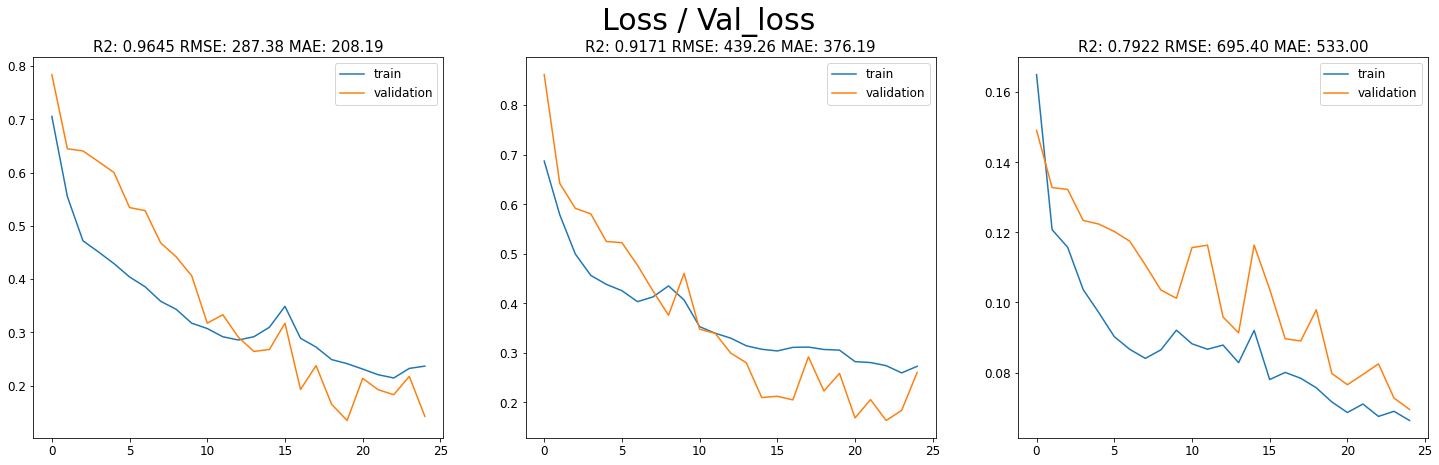

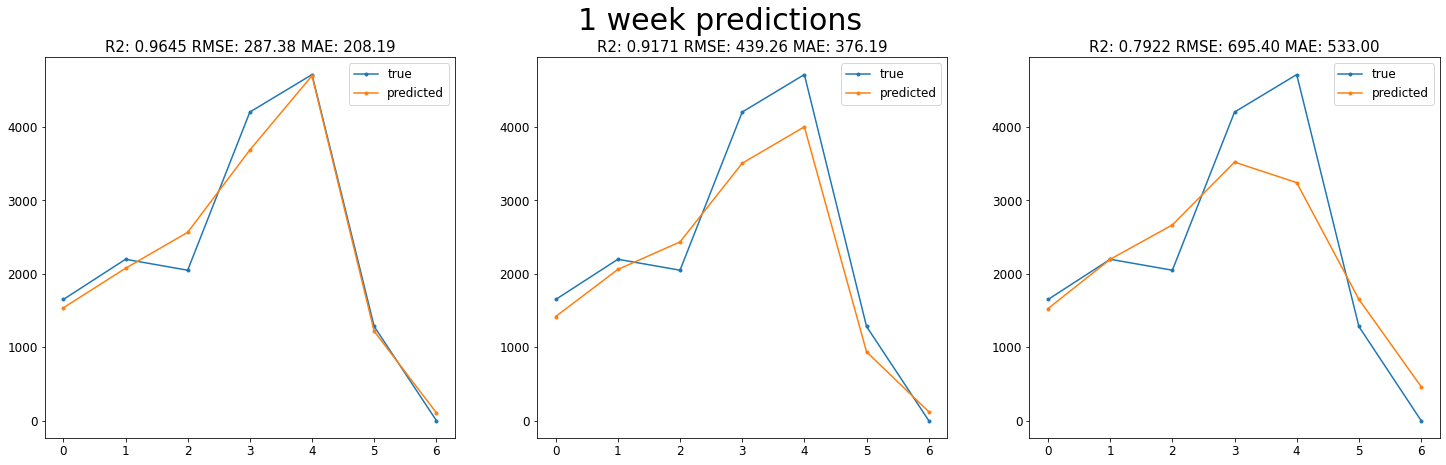

In [23]:
show_results(first_run)

## **Time for hyperparameter testing**
* **Epochs**
* **Merge_mode** (Biderectional specific)
* **Layers**
* **Units / Neurons**
* **Optimizer**
    * **Loss**
    * **Learning_rate**
* **Batch_size**
* **activation functions**

In [24]:
from IPython import display

In [ ]:
display.Image("./Presentation/paramtest.png")

In [25]:
# Here we decide what we wanna test, and how much we want to test. At most we ran 2000 difrent parameter/Model tests.


def hyper_param_test(df_list):
    epochs = [100] # 25, 50, 100, 150, 200, 250, 300
    merge_modes = ['sum'] # 'mul', 'ave', 'concat', 'sum'
    units = [128]
    optimizers = ['nadam'] # 'SGD', 'adam', 'nadam'
    losses = ['mae'] # 'mae', 'mse'
    batch_sizes = [32]
    activation_functions = ['linear'] # 'linear', 'relu', 'softmax'
    model_number = 1    
    return_df = []
    for i, df in enumerate(df_list, 1):
        loop_index = 1
        hyper_param_df = []
        
        for epoch in epochs:
            for merge_mode in merge_modes:
                for unit in units:
                    for optimizer in optimizers:
                        for loss in losses:
                            for batch_size in batch_sizes:
                                for activation_function in activation_functions:
                                    model = Sequential()
                                    model.add(Bidirectional(LSTM(units=unit, input_shape=(df['X_train'].shape[1], df['X_train'].shape[2])), merge_mode=merge_mode))
                                    model.add(Dense(units=1))
                                    model.compile(loss=loss, optimizer=optimizer)

                                    print(f'Training Model {i}/{len(df_list)}'.center(50, '-'))
                                    print(f'Hyper_param_test {loop_index} / {sum([len(epochs) * len(merge_modes) * len(units) * len(optimizers) * len(losses) * len(batch_sizes) * len(activation_functions)])}')
                                    
                                    history = model.fit(
                                    df['X_train'], df['y_train'],
                                    epochs=epoch,
                                    batch_size=batch_size,
                                    validation_data=(df['X_test'], df['scaler_y'].transform(df['y_test'])),
                                    shuffle=False,
                                    verbose=0
                                    )

                                    df['history'] = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}

                                    predictions = model.predict(df['X_test'])
                                    
                                    if df['scaler_y']:
                                        df['predictions'] = df['scaler_y'].inverse_transform(predictions)
                                    else:
                                        df['predictions'] = predictions

                                    df['score'] = {'RMSE': np.sqrt(mean_squared_error(y_true=df['y_test'], y_pred=df['predictions'])),
                                                   'MAE': mean_absolute_error(y_true=df['y_test'], y_pred=df['predictions']),
                                                   'r2': r2_score(y_true=df['y_test'], y_pred=df['predictions'])}
                                    
                                    model_name = f"./presentation/model_{model_number}"
                                    
                                    hyper_param_dict = {
                                        'hyper_params': {
                                            'epochs': epoch,
                                            'merge_mode': merge_mode,
                                            'units': unit,
                                            'optimizer': optimizer,
                                            'loss': loss,
                                            'batch_size': batch_size,
                                            'activation_function': activation_function
                                        },
                                        'model_name': model_name
                                    }
                                    
                                    new_df = {**df.copy(), **hyper_param_dict}
                                    
                                    hyper_param_df.append(new_df)
                                    return_df.append(new_df)
                                    #model.save(f"presentation/model_{model_number}")
                                    model_number += 1
                                    loop_index += 1
                        
        #save_results(hyper_param_df, i)
    return return_df

In [26]:
# Also a good time to save your work so far.

import pickle
def save_results(df_list, name):
    with open(f'presentation/model_{name}.pkl', 'wb') as f:
        pickle.dump(df_list, f)

In [27]:
second_run = hyper_param_test(time_step_data)

----------------Training Model 1/3----------------
Hyper_param_test 1 / 1
----------------Training Model 2/3----------------
Hyper_param_test 1 / 1
----------------Training Model 3/3----------------
Hyper_param_test 1 / 1


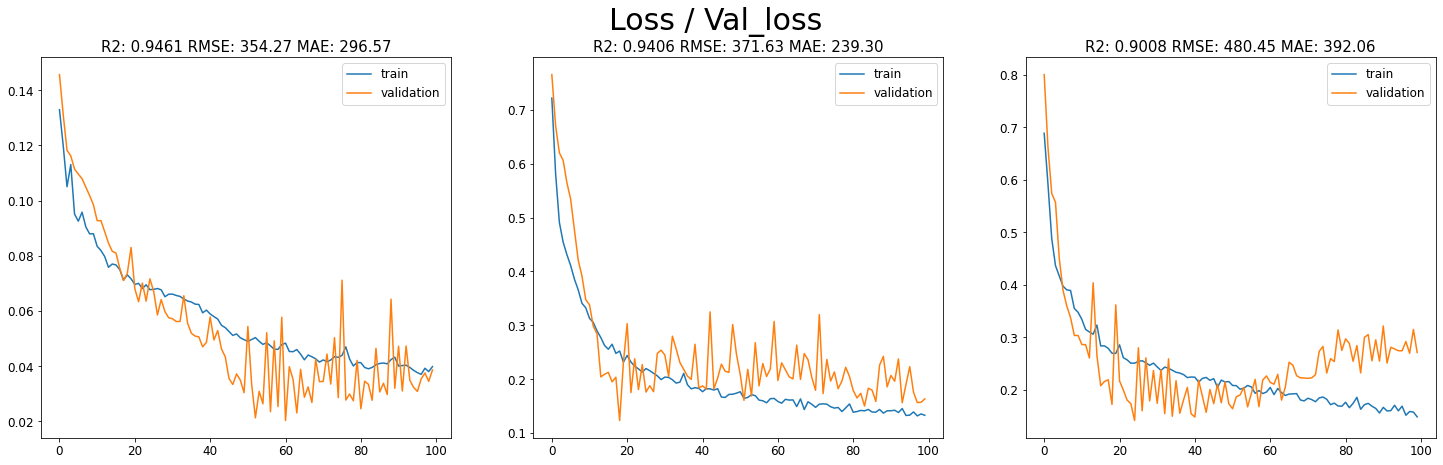

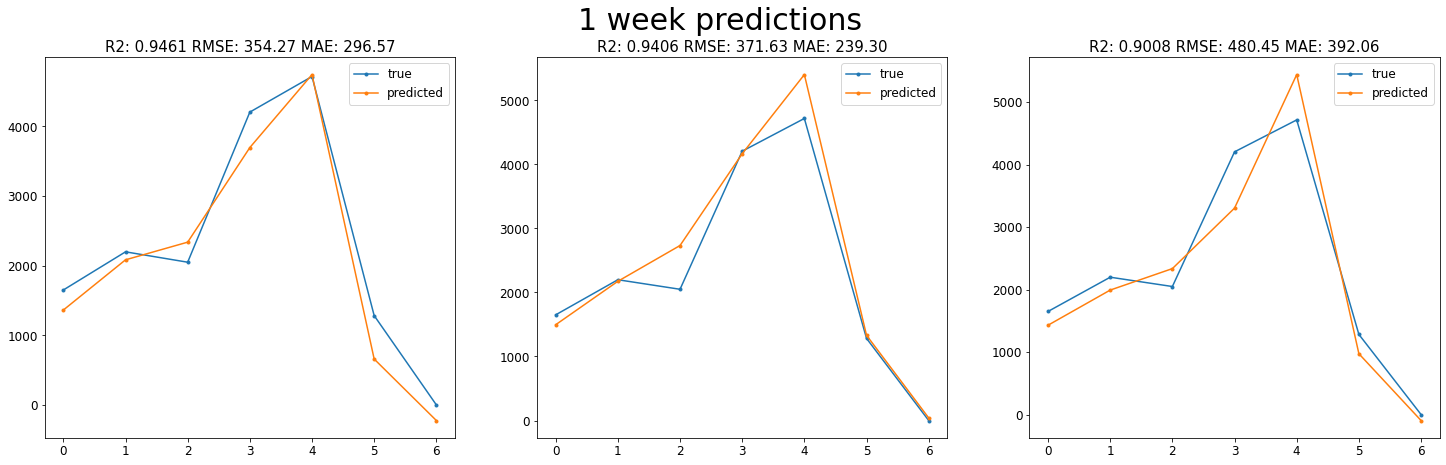

In [28]:
show_results(second_run)

## Now that we've finished checking for diffrent params, we use this to predict our data
First we get the original datafile to have something to compare to.  
Then we try and predicting the next 7 days

In [29]:
def open_original(name):
    with open(f'./original/{name}.pkl', 'rb') as f:
        return pickle.load(f)

In [30]:
original_ica = open_original('complete_ica')

In [31]:
def predict_on_predictions(df_list, original_df, start_pred='2021-03-22', predict_days=7):
    next_week_predictions = []
    start_pred = pd.to_datetime(start_pred)
    for df in df_list:
        next_week_x = original_df.loc[start_pred:start_pred + pd.to_timedelta(predict_days - 1, unit='d'), df['features']]
        x_test = df['scaler_x'].transform(original_df.loc[start_pred - pd.to_timedelta(df['time_steps'], unit='d'): start_pred - pd.to_timedelta(1, unit='d'), df['features']])
        x_test = pd.DataFrame(x_test, columns=df['features'])
        y_test = original_df.loc[start_pred: start_pred + pd.to_timedelta(predict_days - 1, unit='d'), 'artiklar']
        next_week_x['artiklar'] = y_test.values
        next_week_x = next_week_x[df['features']]
        x_test['pred_artiklar'] = x_test['artiklar']
        
        scaled_next_week = pd.concat((x_test, pd.DataFrame(df['scaler_x'].transform(next_week_x[df['features']]), columns=x_test.columns[:-1])))
        model = keras.models.load_model(df['model_name']) # ./fitted_models/model_218 -  df['model_name']
        
        cols = list(scaled_next_week.columns)
        a, b = cols.index('artiklar'), cols.index('pred_artiklar')
        cols[b], cols[a] = cols[a], cols[b]
        scaled_next_week = scaled_next_week[cols]
        
        for i in range(predict_days):
            y_pred = model.predict(scaled_next_week.iloc[i:i + df['time_steps'], :-1].to_numpy().reshape(-1, df['X_train'].shape[1], df['X_train'].shape[2]))
            scaled_next_week.iloc[(i + df['time_steps']), 0] = y_pred[0]

        for i in ['artiklar', 'pred_artiklar']:
            scaled_next_week[i] = df['scaler_y'].inverse_transform(scaled_next_week[i].to_numpy().reshape(-1, 1))

        next_week_pred = scaled_next_week.reset_index(drop=True)
        df['next_week'] = next_week_pred
        y_pred = df['next_week'].iloc[-predict_days:, 0]
        y_true = y_test.to_numpy().reshape(-1, 1)
         
        df['new_score'] = {'RMSE': np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred)),
                           'MAE': mean_absolute_error(y_true=y_true, y_pred=y_pred),
                           'r2': r2_score(y_true=y_true, y_pred=y_pred)}
        df['predicted_days'] = predict_days
        next_week_predictions.append(df)

    return next_week_predictions

In [32]:
next_week_predictions = predict_on_predictions(second_run, original_ica, start_pred='2021-03-10', predict_days=28)

OSError: SavedModel file does not exist at: ./presentation/model_3\{saved_model.pbtxt|saved_model.pb}

## All thats left now is to check our predicted data

In [ ]:
def plot_all_predictions(df_list):
    
    rows = len(df_list) // 3 if len(df_list) % 3 == 0 else (len(df_list) // 3) + 1
    
    fig, axes = plt.subplots(rows, 3, figsize=(25, 7))
    fig.suptitle('Next week predictions', size=30)
    axes = axes.flatten()
    
    # TODO Fill between graphs
    for i, ax in enumerate(axes):
        ax.set_title(f'R2: {df_list[i]["new_score"]["r2"]:0.4f} RMSE: {df_list[i]["new_score"]["RMSE"]:0.2f} MAE: {df_list[i]["new_score"]["MAE"]:0.2f}', size=15)
        ax.plot(df_list[i]['next_week']['artiklar'], label='True', marker='.')
        ax.plot(df_list[i]['next_week'].iloc[-df_list[i]['predicted_days']: ,0], label='Predicted', marker='.')
        ax.legend(loc="lower left", prop={'size': 12})
        ax.tick_params(labelsize=12)
        if i == len(df_list) - 1:
            break

In [ ]:
plot_all_predictions(next_week_predictions)

In [ ]:
stop = time.perf_counter()
print("Entire Presentation notebook took", stop - start, "to run")

## **Ending notes**  

* **Positives**
    * Takes good input from features.
    * Lots of diffrent settings and fine tuning possibility.
    * Fairly easy to comprehend, making it very informative to have as a first time project.
    
* **Negatives**
    * Initial weights to model has way to big of an impact, compared to the model it self  
      making random_seed feel more important than parameters.
    * Lots of diffrent settings, hard to know wich impact. (if any all settings have)
    * Takes a long time to train.